# Evaluation of PAAM static offset angle for correctness 

In [26]:
import numpy as np
from matplotlib import pyplot
import transforms3d as t3d
import pytransform3d as p3d
from pytransform3d.transform_manager import TransformManager

## Definitions of Coordinate Frames

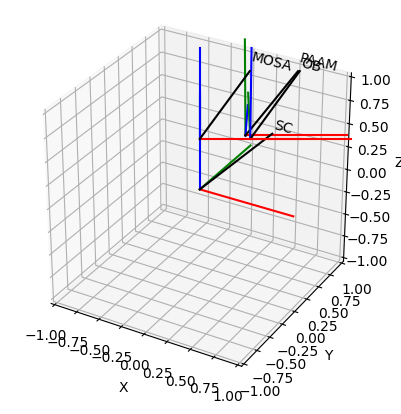

In [27]:
tm = TransformManager()

sc2mosa1 = p3d.transformations.transform_from(p3d.rotations.passive_matrix_from_angle(2, 30./180.*np.pi),[0,-1,0])
mosa2ob = p3d.transformations.transform_from(p3d.rotations.passive_matrix_from_angle(2, 0.),[-0.5,0,0])
ob2paam = p3d.transformations.transform_from(p3d.rotations.passive_matrix_from_angle(0, 45./180.*np.pi),[0.05,0,-0.12])

tm.add_transform("SC","MOSA", sc2mosa1)
tm.add_transform("MOSA","OB", mosa2ob)
tm.add_transform("OB","PAAM", ob2paam)

# definition of the rotation matrix that rotates the paam mirror normal in the OB frame aroung the paam eta angle
paam_static_rotation_OB =  lambda rot: t3d.axangles.axangle2mat([0,-1,-1], rot, is_normalized=False) 

ax = tm.plot_frames_in("SC", s=1)

pyplot.show()

tm.write_png("test.png")

## Trace inside OB Frame

In [28]:
def trace_paam_effect(paam_static_rot=0, getrace=False):

    paam_normal_OB= paam_static_rotation_OB(paam_static_rot) @ t3d.utils.normalized_vector([0,   -1.0,   1.0 ])
    beam_pre_paam_OB        = t3d.utils.normalized_vector([0,   1.0,    0   ])
    pbs1_normal_OB          = t3d.utils.normalized_vector([0,   -1.0,   -1.0])
    telif_normal_OB         = t3d.utils.normalized_vector([1.0, 1.0,    0   ])

    ## Generate Reflection Matrices

    paam_reflection_OB      = t3d.reflections.rfnorm2mat(paam_normal_OB)
    pbs1_reflection_OB      = t3d.reflections.rfnorm2mat(pbs1_normal_OB)
    telif_reflection_OB     = t3d.reflections.rfnorm2mat(telif_normal_OB)

    tx_beam_exit_OB = telif_reflection_OB @ pbs1_reflection_OB @ paam_reflection_OB @ beam_pre_paam_OB

    if getrace:
        pass
    else:
        return tx_beam_exit_OB

In [29]:
tx_original_exit_OB = trace_paam_effect()
tx_mod_exit_OB = trace_paam_effect(-0.000221/2**0.5)  ## -156.27 matching the current requirement
rotation = np.cross(tx_original_exit_OB, tx_mod_exit_OB)

## Post

In [34]:
print(f"original beam : {tx_original_exit_OB}")
print(f"offset beam   : {tx_mod_exit_OB}")
print(f"rotation      : {rotation}")
print("Check for requirement in OB Frame:")
print({False: "!!! The requirement is not met !!!", True: "The static offset pointing is compliant"}[np.isclose(rotation[2],-0.000221)])
print("Check for requirement in SC Frame:")
sc_rotation = tm.get_transform("OB","SC") @ np.append(rotation,[0])
print({False: "!!! The requirement is not met !!!", True: "The static offset pointing is compliant"}[np.isclose(sc_rotation[2],-0.000221)])


original beam : [1. 0. 0.]
offset beam   : [ 9.99999976e-01 -2.20999996e-04 -2.44204998e-08]
rotation      : [ 0.00000000e+00  2.44204998e-08 -2.20999996e-04]
Check for requirement in OB Frame:
The static offset pointing is compliant
Check for requirement in SC Frame:
The static offset pointing is compliant


The requirement of -221µrad rotation around Z in OB frame is met, nota bene: the secondary effect in 4 orders of magnitude smaller, a 0.2µrad rotation around y which is small enough to be neglected in the alignment budget.
For this to verify also beyond OB frame, it needs to be enforced that OB Z is coalligned with MOSA and SC Z.

### some sanity checks

In [31]:
# plot the trace in 3d with the coordinate frames visualized

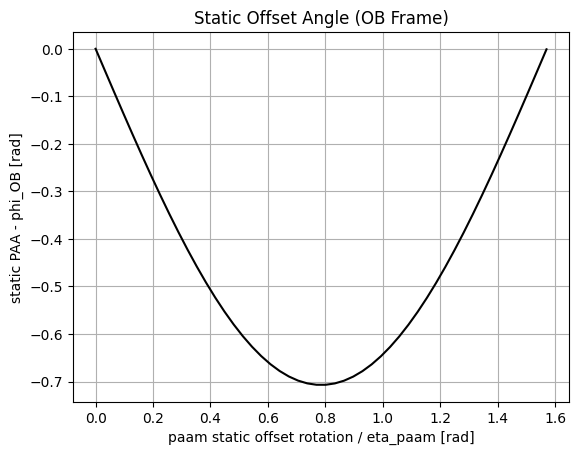

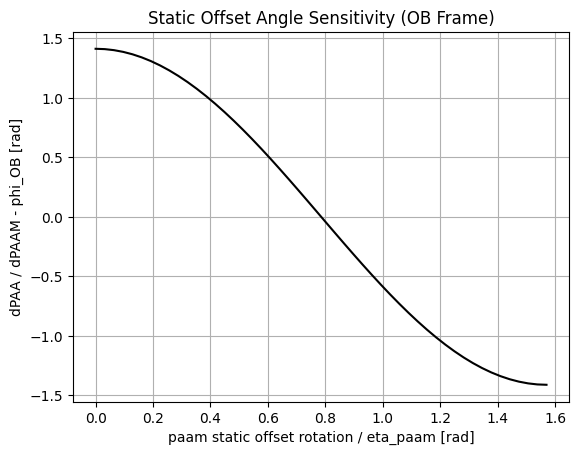

In [32]:
rotation_OB_z = [np.cross(tx_original_exit_OB, trace_paam_effect(rot))[-1] for rot in np.linspace(0,-3.14/2)]

pyplot.figure()
pyplot.plot(np.linspace(0,3.14/2),rotation_OB_z, 'black')
pyplot.title("Static Offset Angle (OB Frame)")
pyplot.xlabel("paam static offset rotation / eta_paam [rad]")
pyplot.ylabel("static PAA - phi_OB [rad]")
pyplot.grid("Both")
pyplot.figure()
pyplot.plot(np.linspace(0,3.14/2),np.gradient((rotation_OB_z),np.linspace(0,-3.14/2)), 'black')
pyplot.title("Static Offset Angle Sensitivity (OB Frame)")
pyplot.xlabel("paam static offset rotation / eta_paam [rad]")
pyplot.ylabel("dPAA / dPAAM - phi_OB [rad]")
pyplot.grid("Both")

## Propagate to Spacecraft and Constellation Frame 
....to be implemented